# Main steps for Web usage mining of log files :

1. Loading the log file: loading it into RDDs, We’ll do this in steps:
          1. First, we will use sqlContext.read.text() to read the text file.
2. Parsing the log file:
          1. We’ll use one regular expression for each field we want to extract
3. Data Cleaning :    
          1. we verify that there are no null rows in the original data set.
          2. The second step is the removal of graphical contents (audio, video, images).
4. Do some statistics on the result of the Cleaning step.    


In [1]:
# Function to parse the log file, by using RegLex
import re
import datetime

from pyspark.sql import Row
import pandas as pd


# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


ModuleNotFoundError: No module named 'pyspark'

In [2]:

def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = int(0)
    else:
        size = int(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)




In [3]:
import sys
import os

logFile = os.path.abspath('access_log_Aug95')

def parseLogs():
    """ Read and parse log file """
    parsedLogs=sc.textFile(logFile).map(parseApacheLogLine)
    accessLogs=parsedLogs.filter(lambda s:s[1]==1).map(lambda s:s[0])# Regrouping the good rows 
    failedLogs=parsedLogs.filter(lambda s:s[1]==0).map(lambda s:s[0])# Regrouping the bad rows(failed to parsed)
    
    print ('Read %d lines, parsed %d file sucessfully, failed to parse %d ' % (parsedLogs.count(),accessLogs.count()
    ,failedLogs.count()))
    return parsedLogs,accessLogs,failedLogs


parsed_logs,access_logs,failed_logs=parseLogs()



Read 1569898 lines, parsed 1569003 file sucessfully, failed to parse 895 


In [4]:
#  The removal of graphical contents

cleanedLogs = access_logs.filter(lambda s: "gif" not in s.endpoint).filter(lambda s: "jpg" not in s.endpoint).filter(lambda s: "png" not in s.endpoint).cache()
print(cleanedLogs.count())

606400


In [5]:
# Calculate statistics based on the content size.

content_sizes = access_logs.map(lambda log: log.content_size)
print ('Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max()))


Content Size Avg: 17097, Min: 0, Max: 3421948


In [6]:
responseCodeCount = access_logs.map(lambda log:(log.response_code,1)).reduceByKey(lambda a,b:a+b).cache()
responseCodeToCountList = responseCodeCount.take(10)

print (responseCodeToCountList)

[(200, 1398207), (500, 3), (501, 27), (302, 26437), (403, 171), (304, 134138), (404, 10020)]


In [7]:
# Computing and Plotting the Frequency of Each Response Code

labels = responseCodeCount.map(lambda x: x[0]).collect()
print (labels)
count = access_logs.count()
fracs = responseCodeCount.map(lambda x: (float(x[1]) / count)).collect()
print (fracs)

[200, 500, 501, 302, 403, 304, 404]
[0.8911436115800926, 1.9120422331888467e-06, 1.720838009869962e-05, 0.01684955350627118, 0.00010898640729176426, 0.08549250702516184, 0.006386221058850748]


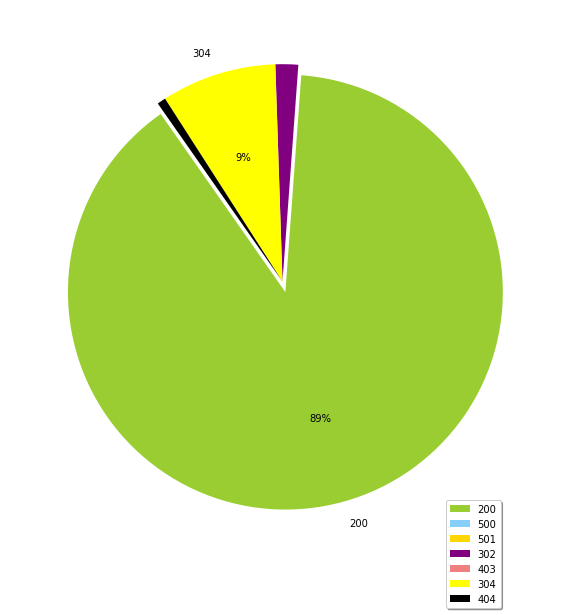

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(10, 10), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

In [9]:
# Top Endpoints with 200 on status
topEndpoints = (cleanedLogs
                .filter(lambda log: log.response_code == 200)
                .map(lambda log: (log.endpoint, 1))
                .reduceByKey(lambda a, b : a + b)
                .takeOrdered(10, lambda s: -1 * s[1]))
topEndpoints.sort(key= lambda tup : tup[1],reverse=True)
pd.DataFrame( topEndpoints, columns=['endPoint','Number of Access'])

,endPoint,Number of Access
0,/ksc.html,41392
1,/,26722
2,/shuttle/missions/sts-69/mission-sts-69.html,23248
3,/shuttle/countdown/,22244
4,/shuttle/missions/missions.html,20715
5,/htbin/cdt_main.pl,17245
6,/icons/menu.xbm,10726
7,/icons/blank.xbm,10582
8,/history/history.html,9504
9,/software/winvn/winvn.html,9251


In [10]:
# Any IPAddress that has accessed the server more than 10 times.

ipAddresses = (cleanedLogs
               .map(lambda log: (log.host, 1))
               .reduceByKey(lambda a, b : a + b)
               .filter(lambda s: s[1] > 10)
               .take(10))
ipAddresses.sort(key= lambda tup : tup[1],reverse=True)
pd.DataFrame( ipAddresses, columns=['Host','Number of Access'])

,Host,Number of Access
0,www-d3.proxy.aol.com,1523
1,bdmgate.bdm.com,237
2,reggae.iinet.net.au,99
3,gikai.eng.nhk.or.jp,97
4,uplherc.upl.com,40
5,chuken02.shinshu-u.ac.jp,32
6,adam.tower.com.au,24
7,dd09-012.compuserve.com,19
8,dialup-2-139.gw.umn.edu,17
9,k12.oit.umass.edu,17


In [11]:
# accesses that did not return a code 200
not200DF = (cleanedLogs.filter(lambda log:log.response_code !=200)
                      .map(lambda log: (log.endpoint, 1))
                      .reduceByKey(lambda a, b : a + b)
                      .take(10))

print("Top Ten failed URLs:")
not200DF.sort(key= lambda tup : tup[1],reverse=True)
pd.DataFrame( not200DF, columns=['endPoint','Number of Failed access'])

Top Ten failed URLs:


,endPoint,Number of Failed access
0,/,3605
1,/ksc.html,2291
2,/pub/winvn/readme.txt,1337
3,/history/apollo/a-001/images/,29
4,"/cgi-bin/imagemap/countdown70?62,224",2
5,"/cgi-bin/imagemap/countdown70?54,211",1
6,"/cgi-bin/imagemap/countdown70?66,225",1
7,"/cgi-bin/imagemap/countdown70?288,283",1
8,/sts-71/launch/,1
9,"/cgi-bin/imagemap/countdown70?56,190",1


Number of Hits per day


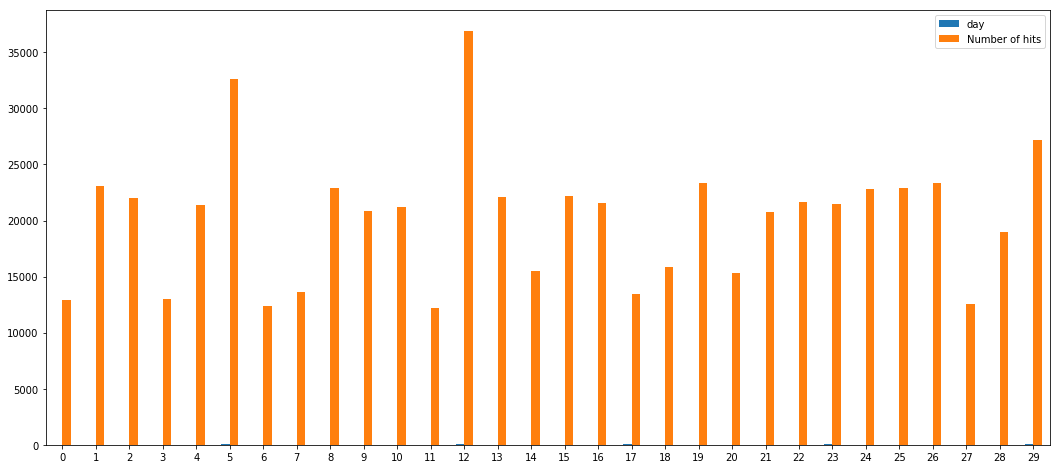

In [12]:
# Number of Hits per day

import pandas as pd
import numpy as np
from pandas import Series, DataFrame, Panel



perMonth =  (cleanedLogs.map(lambda log: (log[2].day  ,1 ))
                       .reduceByKey(lambda a, b : a + b)
                       .map(lambda log: (log[0] ,log[1]))
                       .take(30))

print("Number of Hits per day")
pd.DataFrame( perMonth, columns=['day','Number of hits']).plot(kind='bar',figsize=(18, 8),rot=0)


In [13]:
# the frequency of Each Method
methods =  (cleanedLogs.map(lambda log: (log.method  ,1 ))
                       .reduceByKey(lambda a, b : a + b).collect())
                       
print(methods)         

[('HEAD', 1468), ('GET', 604837), ('POST', 95)]
